In [1]:
#モジュールの読み込み
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as ds

In [2]:
#MNISTデータの読み込み
# digits は10個の数字を扱うことができる.
MNIST = ds.load_digits()
xdata = MNIST.data.astype(np.float32)
tdata = MNIST.target.astype(np.int32)

In [3]:
# 数字の配列の形のチェックおよび表示
D, N = xdata.shape
print(D,N)

1797 64


In [4]:
# D=1797個のデータがあり, 一つ一つがN=64個の数字からなることがわかった.
# digitsを使っているので, 10個の数字のデータが64この数字からなることを意味している.

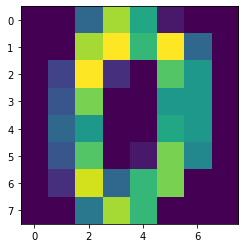

In [5]:
# 画像データの表示
# .reshape(8,8)によって, 縦横8x8のデータに整形.
# また, plt.imshowで数値のデータを画像として表示する準備をしている.
plt.imshow(xdata[0,:].reshape(8,8))
plt.show()

In [6]:
# ラベルの表示
print(tdata)

[0 1 2 ... 8 9 8]


In [7]:
# データ分割の自作関数
def data_divide(Dtrain, D, xdaa, tdata):
    index = np.random.permutation(range(D))
    xtrain = xdata[index[0:Dtrain],:]
    ttrain = tdata[index[0:Dtrain]]
    xtest = xdata[index[Dtrain:D], :]
    ttest = tdata[index[Dtrain:D]]
    return xtrain, xtest, ttrain, ttest

In [8]:
# データ分割の自作関数の利用
Dtrain = D//2
xtrain, xtest, ttrain, ttest = data_divide(Dtrain, D, xdata, tdata)

In [9]:
# chainerの宣言
import chainer.optimizers as Opt
import chainer.functions as F
import chainer.links as L
from chainer import Variable, Chain, config

/anaconda3/envs/princess/lib/python3.7/site-packages/chainer/_environment_check.py:41: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


In [10]:
# ２層ニューラルネットワークを呼び出す
C = tdata.max() + 1
NN = Chain( l1 = L.Linear(N, 20), l2 = L.Linear(20, C))

In [11]:
# ２層ニューラルネットワークの関数化
def model(x):
    h = NN.l1(x)
    h = F.relu(h)
    y = NN.l2(h)
    return y

In [12]:
# 最適化手法の設定
# 今回はモーメント勾配法を採用
optNN = Opt.MomentumSGD()
optNN.setup(NN)

In [13]:
# 学習の記録を残す場所を用意
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [14]:
# 結界の中での最適化の過程と学習成果の記録
T = 200
for time in range(T):
    config.train = True
    optNN.target.zerograds()
    ytrain = model(xtrain)
    loss_train = F.softmax_cross_entropy(ytrain, ttrain)
    acc_train = F.accuracy(ytrain, ttrain)
    loss_train.backward()
    optNN.update()
    
    config.train = False
    ytest = model(xtest)
    loss_test = F.softmax_cross_entropy(ytrain, ttrain)
    acc_test = F.accuracy(ytrain, ttrain)
    train_loss.append(loss_train.data)
    train_acc.append(acc_train.data)
    test_loss.append(loss_test.data)
    test_acc.append(acc_test.data)

In [15]:
# 二つの結果を並べてプロットする自作関数
def plot_result2(result1, result2, title, xlabel, ylabel, ymin = 0.0, ymax = 1.0):
    Tall = len(result1)
    plt.figure(figsize=(8,6))
    plt.plot(range(Tall), result1)
    plt.plot(range(Tall), result2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0, Tall])
    plt.ylim([ymin, ymax])
    plt.show()

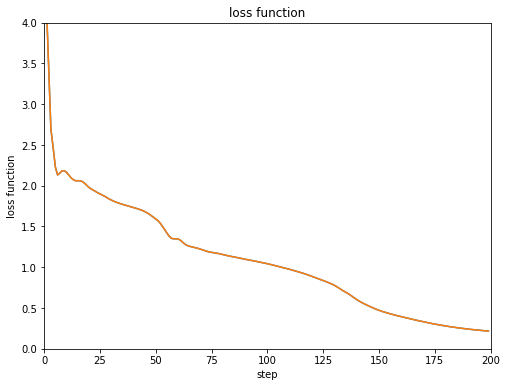

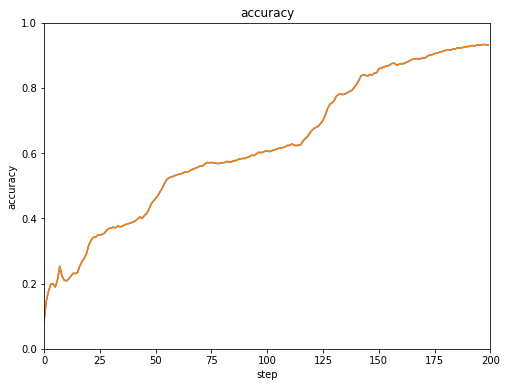

In [16]:
# 学習の記録と成績の記録の表示
plot_result2(train_loss, test_loss, "loss function", "step", "loss function", 0.0, 4.0)
plot_result2(train_acc, test_acc, "accuracy", "step", "accuracy")

In [17]:
# 大型データセットの読み込み準備
import chainer.datasets as ds

In [18]:
# MNIST データの読み込み
train, test = ds.get_mnist()

In [19]:
# 入力とラベルの取り出し
import chainer.dataset.convert as con
xtrain, ttrain = con.concat_examples(train)
xtest, ttest = con.concat_examples(test)

60000 784


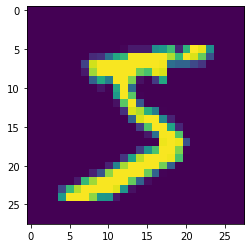

In [20]:
# データの形とMNIST originalの１例を表示する
Dtrain, N = xtrain.shape
print(Dtrain,N)
plt.imshow(xtrain[0,:].reshape(28,28))
plt.show()

In [21]:
# ２層のニューラルネットワークを呼び出して関数化
# はじめにtdataが存在しないことから, ttrainの中から最大値をとって, C=10となるように仕様変更している.
C = ttrain.max() + 1
NN = Chain(l1 = L.Linear(N, 400), l2 = L.Linear(400, C), bnorm1 = L.BatchNormalization(400))
# bnormでニューラルネットワークにバッチ規格化を導入している.
# NNには線形変換や非線形変換以外にも様々な操作が存在する.
# その一つがバッチ規格化であり, 様々なデータが次から次へと何度も変換が咥えられるので、途中の結果の整理整頓を行う役割を担う.
# これにより, 学習の安定化ができる. 引数は途中の結果がいくつ用意されるかに応じて変更する.
# 今回はN=784から400へと絞り, 最終的にC=10個の識別を行う. そのため、400という数字を設定した.
def model(x):
    h = NN.l1(x)
    h = F.relu(h)
    # バッチ規格化の導入.
    h = NN.bnorm1(h)
    y = NN.l2(h)
    return y

In [22]:
# 識別用の結界を張る自作関数
def learning_classification(model, optNN, data, result, T=50):
    for time in range(T):
        config.train = True
        optNN.target.zerograds()
        ytrain = model(data[0])
        loss_train = F.softmax_cross_entropy(ytrain, data[2])
        acc_train = F.accuracy(ytrain, data[2])
        loss_train.backward()
        optNN.update()
        # バッチ規格化をはじめ, いくつかのものはそのまま利用してしまうと, 
        # 訓練データを利用する際とテストデータを利用する際において違う結果を招くことがある.
        config.train = False
        ytest = model(data[1])
        loss_test = F.softmax_cross_entropy(ytest, data[3])
        acc_test = F.accuracy(ytest, data[3])
        result[0].append(loss_train.data)
        result[1].append(loss_test.data)
        result[2].append(acc_train.data)
        result[3].append(acc_test.data)

In [23]:
# 最適化手法の設定
optNN = Opt.MomentumSGD()
optNN.setup(NN)

# データと学習の記録を残す場所の用意
train_loss = []
train_acc = []
test_loss = []
test_acc = []
data = [xtrain, xtest, ttrain, ttest]
result = [train_loss, test_loss, train_acc, test_acc]

In [27]:
# 学習回数を変える際には, 最後の引数に T = 100 などを加える.
learning_classification(model, optNN, data, result, 10)

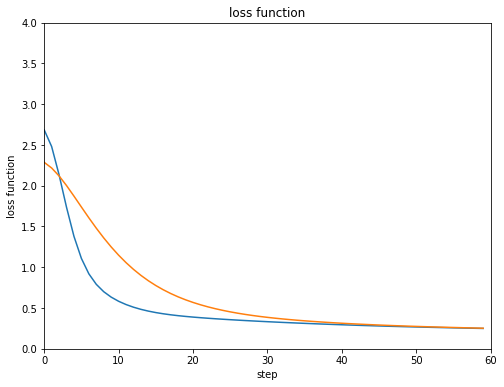

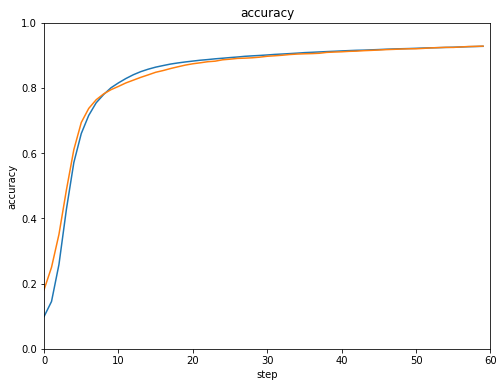

In [28]:
# 自作関数による結果の表示
plot_result2(result[0], result[1], "loss function", "step", "loss function", 0.0, 4.0)
plot_result2(result[2], result[3], "accuracy", "step", "accuracy")

In [29]:
# GPGPUの利用
from chainer import cuda
gpu_device = 0
cuda.get_device(gpu_device).use()
# cuda.get_device(gpu_device).use()
# NN.to_gpu()

RuntimeError: CUDA environment is not correctly set up
(see https://github.com/chainer/chainer#installation).No module named 'cupy'